# **Final Project**

# Read dataset

In [25]:
!pip install contractions langdetect emoji textstat

## Import library

In [26]:
import html
import os
import quopri
import re
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from textstat import textstat

import emoji
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from langdetect import detect, LangDetectException
from tqdm import tqdm

import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    XLNetForSequenceClassification,
    get_scheduler,
)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [27]:
true_df = pd.read_csv("/kaggle/input/misinfo/DataSet_Misinfo_TRUE.csv")
true_df

,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...
...,...,...
34970,34970,Most conservatives who oppose marriage equalit...
34971,34971,The freshman senator from Georgia quoted scrip...
34972,34972,The State Department told the Republican Natio...
34973,34973,"ADDIS ABABA, Ethiopia —President Obama convene..."


In [28]:
fake_df = pd.read_csv("/kaggle/input/misinfo/DataSet_Misinfo_FAKE.csv")
fake_df

,Unnamed: 0,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...
...,...,...
43637,44422,The USA wants to divide Syria.\r\n\r\nGreat Br...
43638,44423,The Ukrainian coup d'etat cost the US nothing ...
43639,44424,The European Parliament falsifies history by d...
43640,44425,The European Parliament falsifies history by d...


In [29]:
# Delete order column
true_df = true_df.drop('Unnamed: 0', axis=1)
fake_df = fake_df.drop('Unnamed: 0', axis=1)

In [13]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43642 entries, 0 to 43641
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43642 non-null  object
dtypes: object(1)
memory usage: 341.1+ KB


In [11]:
true_df.describe()

,text
count,34946
unique,34526
top,"Killing Obama administration rules, dismantlin..."
freq,58


In [12]:
fake_df.describe()

,text
count,43642
unique,34078
top,Leave a Reply Click here to get more info on f...
freq,38


# Data Preprocessing

## Missing values

- Check missing values

In [14]:
true_df.isnull().sum()

text    29
dtype: int64

In [15]:
fake_df.isnull().sum()

text    0
dtype: int64

- Handle missing values: Only a small number of rows have null, so we simply drop them.

In [30]:
true_df = true_df.dropna()

## Duplicate

- Check duplicates

In [ ]:
true_df.duplicated().sum()

np.int64(420)

In [ ]:
fake_df.duplicated().sum()

np.int64(9564)

- Remove duplicate rows

In [31]:
true_df = true_df.drop_duplicates()
fake_df = fake_df.drop_duplicates()

## Concatenate and label datasets

- Add label column and merge the two datasets

In [32]:
true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle dataset
df

,text,label
0,Former Russian economy minister Alexei Ulyukay...,1
1,Republicans were just given a leg up over Demo...,0
2,This has to be one of the best remix videos ev...,0
3,"In line with the new Language Law, Russian is ...",0
4,JERUSALEM — A day after approving the const...,1
...,...,...
68599,The Super Bowl had not yet begun and Trump fan...,0
68600,U.S. House Republicans on Friday won passage o...,1
68601,Share on Facebook Share on Twitter Known to th...,0
68602,A New Jersey man who worked at the World Trade...,1


- Check whether the label distribution is imbalanced

In [20]:
df['label'].value_counts()

label
1    34526
0    34078
Name: count, dtype: int64

=> The dataset is not imbalanced.

In [21]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(0)

## Handle texts that are not in English

In [ ]:
def safe_detect(x):
    if isinstance(x, str) and x.strip() and len(x.strip()) > 20:
        try:
            return detect(x)
        except LangDetectException:
            return 'unknown'
    return 'unknown'

df['lang'] = df['text'].apply(safe_detect)
non_english = df[df['lang'] != 'en']
print(non_english)

                                                    text  label     lang
127                                   Florida for Trump!      0  unknown
253    0 комментариев 0 поделились Фото: AP \nКоммент...      0       ru
294    0 комментариев 7 поделились \n"Это полный бред...      0       ru
297    +++ Beim Jupiter! Spuren römischer Zivilisatio...      0       de
433    0 комментариев 0 поделились \n23 октября в Ниж...      0       ru
...                                                  ...    ...      ...
68104  Mittwoch, 16. November 2016 Neue App ruft auto...      0       de
68347  +++ Muhten ihm einiges zu: Bauer soll Streit u...      0       de
68388  — The Sun (@TheSun) 23. November 2016 Laut Fer...      0       de
68406                       President Obama is a Muslim.      0       pt
68444  Страна: Китай Заявления КНДР о завершении свое...      0       ru

[648 rows x 3 columns]


- Remove the temporary `lang` column after processing

In [ ]:
df = df.drop(columns="lang", axis=1)

In [ ]:
non_english['label'].value_counts()

,count
label,
0,638
1,10


=> Do not remove the non-English rows, because most of them belong to label 0 (fake news), they may serve as a useful signal for the model to distinguish between true and fake news.

## Handle texts with fewer than 5 words

In [ ]:
# Count the number of words in each row
short_texts = df[df['text'].apply(lambda x: len(str(x).split()) < 5)]
print(short_texts)

                                                  text  label
127                                 Florida for Trump!      0
288    A MUST watch video!https://youtu.be/-5Z-jJ2Z4bU      0
772                                               Cool      0
965                    That would be unconstitutional.      0
1115                   Around 120,000 displaced people      1
...                                                ...    ...
67547                           TRUMP VICTORY FOR SURE      0
67689                                        Brilliant      0
67766                                  Good guy.\n👍👍👍👍      0
67797      https://www.youtube.com/watch?v=gqxwF-TeYas      0
67834                                        Horseshit      0

[170 rows x 2 columns]


In [ ]:
# Short text label distribution
short_texts['label'].value_counts()

,count
label,
0,161
1,9


* Remove rows with fewer than 5 words in the text, as they do not carry meaningful information.

In [33]:
df = df[df['text'].apply(lambda x: len(str(x).split()) >= 5)]

## Clean text

In [34]:
def clean_text(row):
    row = str(row).lower()

    # Remove email headers
    row = re.sub(r'(?i)\b(from|to|cc|bcc|subject|date|return-path|message-id|thread-topic|thread-index|content-type|mime-version|boundary|received|x-[\w-]+):.*', ' ', row)

    # Remove mailto links
    row = re.sub(r'mailto:[^\s]+', ' ', row)

    # Decode quoted-printable
    row = quopri.decodestring(row.encode('utf-8')).decode('utf-8', errors='ignore')

    # Unescape HTML entities
    row = html.unescape(row)

    # Strip HTML tags
    if '<' in row and '>' in row:
        row = BeautifulSoup(row, "lxml").get_text()

    # Normalize
    row = re.sub(r'[\t\r\n]', ' ', row)
    row = re.sub(r'[_~+\-]{2,}', ' ', row)
    row = re.sub(r"[<>()|&©ø%\[\]\\~*\$€£¥]", ' ', row)
    row = re.sub(r"\\x[0-9a-fA-F]{2}", ' ', row)
    row = re.sub(r'(https?://)([^/\s]+)([^\s]*)', r'\2', row)
    row = re.sub(r'[a-f0-9]{16,}', ' ', row)
    row = re.sub(r'([.?!])[\s]*\1+', r'\1', row)
    row = re.sub(r'\s+', ' ', row)

    # Remove code-like keywords
    row = re.sub(r'\b(function|var|return|typeof|window|document|eval|\.split)\b', ' ', row)

    # Remove programming symbols
    row = re.sub(r'[{}=<>\[\]^~|`#@*]', ' ', row)

    # Remove all emoji
    row = emoji.replace_emoji(row, replace='')

    # Cut code JS minify or base36 encode
    code_gibberish = re.search(r'[a-z0-9]{20,}', row)
    if code_gibberish and len(row) - code_gibberish.start() > 50:
        row = row[:code_gibberish.start()]

    # Cut off JS/CDATA tail
    cutoff = re.search(
        r'(//\s*!?\s*cdata|function\s*\(|var\s+[a-zA-Z]|window\s*\.\s*|document\s*\.\s*|this\s*\.)',
        row
    )
    if cutoff and len(row) - cutoff.start() > 10:
        row = row[:cutoff.start()]

    row = re.sub(r'!+\s*cdata\s*!+', ' ', row, flags=re.IGNORECASE)

    return row.strip()

df['clean_text'] = df['text'].apply(clean_text)
df['clean_text']

/tmp/ipykernel_35/4079060469.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)


0        former russian economy minister alexei ulyukay...
1        republicans were just given a leg up over demo...
2        this has to be one of the best remix videos ev...
3        in line with the new language law, russian is ...
4        jerusalem — a day after approving the construc...
                               ...                        
68599    the super bowl had not yet begun and trump fan...
68600    u.s. house republicans on friday won passage o...
68601    share on facebook share on twitter known to th...
68602    a new jersey man who worked at the world trade...
68603    turkey and iran have agreed to discuss within ...
Name: clean_text, Length: 68434, dtype: object

### Enhanced Text Preprocessing (for Machine Learning Model: TF-IDF + Linear SVM)

In [13]:
# The first running
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
stemmer    = PorterStemmer()
stop_words = set(stopwords.words("english"))
tokenizer_regex = RegexpTokenizer(r"[A-Za-z']+")

In [13]:
def tokenize_and_filter(text):
    text   = contractions.fix(text)
    tokens = tokenizer_regex.tokenize(text)
    return [stemmer.stem(w)
            for w in tokens
            if w.lower() not in stop_words]

# Exploratory Data Analysis (EDA)

## Label Analysis

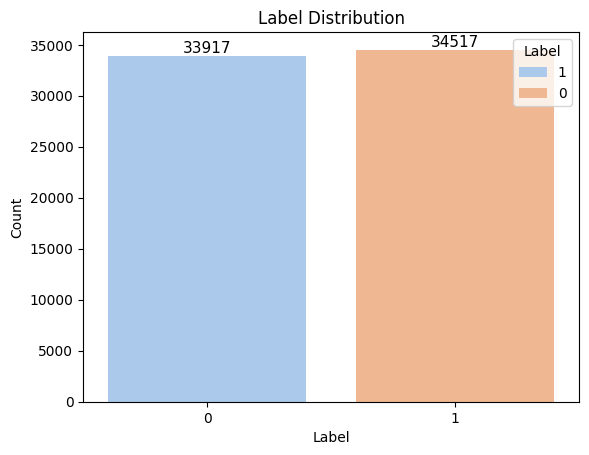

In [ ]:
def plot_label_distribution(df, label_col):
    ax = sns.countplot(x=label_col, data=df, hue=label_col, palette='pastel', dodge=False)

    counts = df[label_col].value_counts().sort_index()
    for x, y in enumerate(counts.values):
        ax.text(x, y, f'{y}', ha='center', va='bottom', fontsize=11)

    plt.legend(title='Label', labels=df[label_col].unique(),)
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_label_distribution(df, 'label')

The difference between the two labels is very small (only 448 samples), indicating that the dataset is fairly balanced between the two classes.

## Distribution Analysis

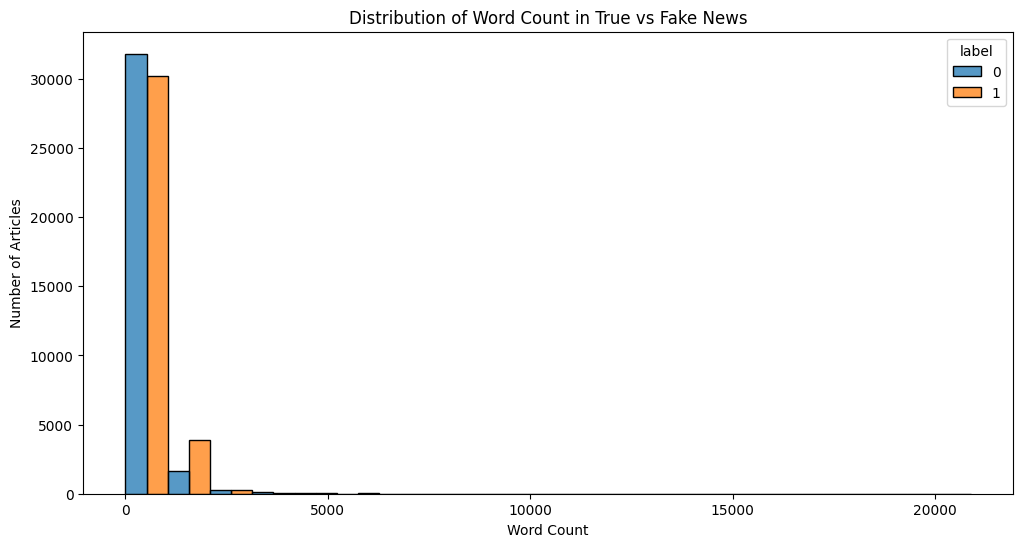

In [ ]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', multiple='dodge', bins=20)
plt.title('Distribution of Word Count in True vs Fake News')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

Most articles (around 30,000) contain between 0 and 5,000 words, for both True News and Fake News, with label 0 (True News) being slightly more dominant. Very few articles exceed 5,000 words, indicating that the distribution is primarily concentrated on short to medium-length articles.

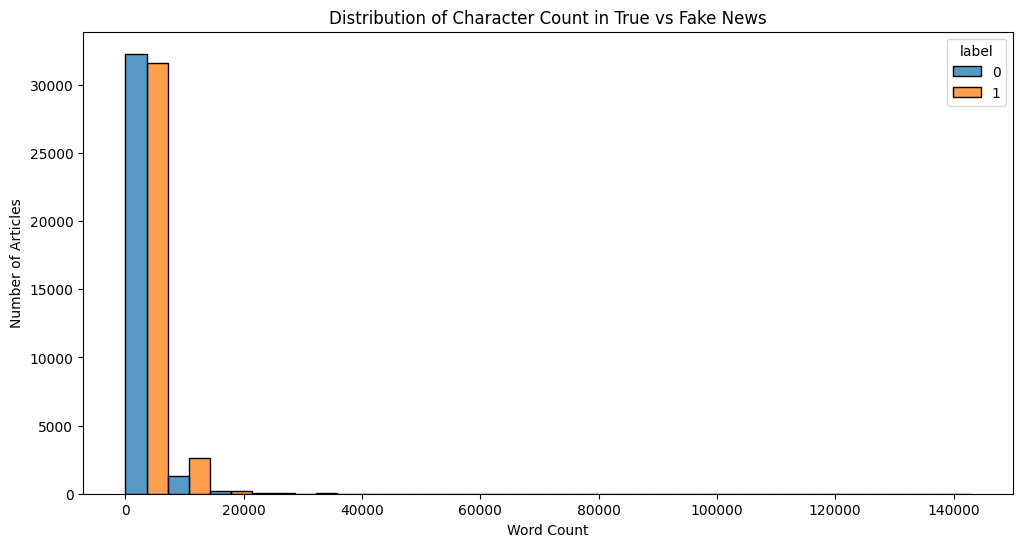

In [ ]:
df['char_count'] = df['clean_text'].apply(lambda x: len(x))
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='char_count', hue='label', multiple='dodge', bins=20)
plt.title('Distribution of Character Count in True vs Fake News')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

Most articles (around 30,000) have between 0 and 20,000 characters, with label 0 (True News) being dominant. The number drops steeply beyond 20,000 characters, indicating a concentration of articles with low to medium character counts.

## Word Frequency Analysis

### Word Distribution Analysis

In [ ]:
true_words = ' '.join(df[df['label'] == 1]['clean_text']).split()
true_words = set(true_words)

fake_words = ' '.join(df[df['label'] == 0]['clean_text']).split()
fake_words = set(fake_words)

common_words = true_words.intersection(fake_words)

unique_true_words = true_words - common_words
unique_fake_words = fake_words - common_words

print(f"Number of common words between true and fake news: {len(common_words)}")
print(f"Number of unique words in true news: {len(unique_true_words)}")
print(f"Number of unique words in fake news: {len(unique_fake_words)}")

Number of common words between true and fake news: 137206
Number of unique words in true news: 176779
Number of unique words in fake news: 293532


### Top Common Words

/tmp/ipython-input-46-2636505219.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in most_common_true], y=[word[0] for word in most_common_true], palette= "viridis")


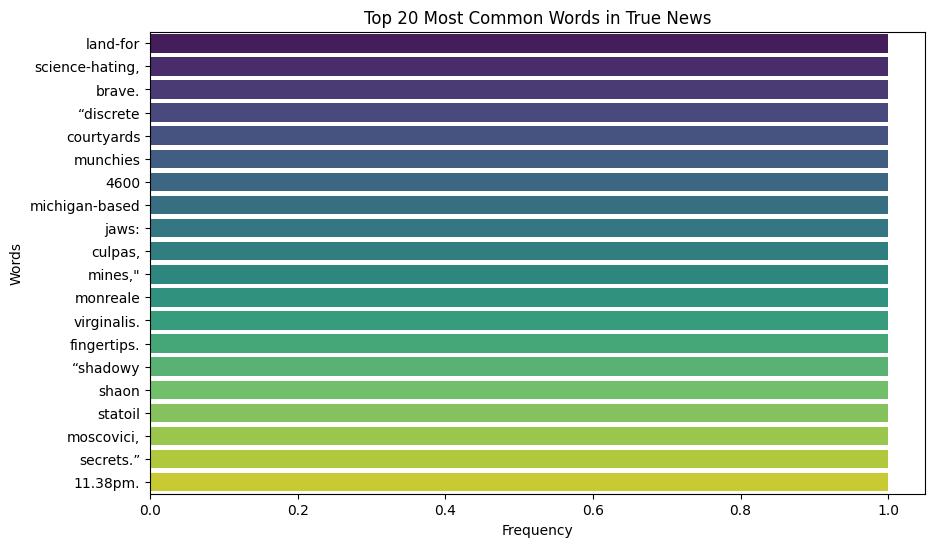

In [ ]:
true_word_freq = Counter(true_words)
most_common_true = true_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_true], y=[word[0] for word in most_common_true], palette= "viridis")
plt.title('Top 20 Most Common Words in True News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

/tmp/ipython-input-47-1258931107.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in most_common_fake], y=[word[0] for word in most_common_fake], palette = "viridis")


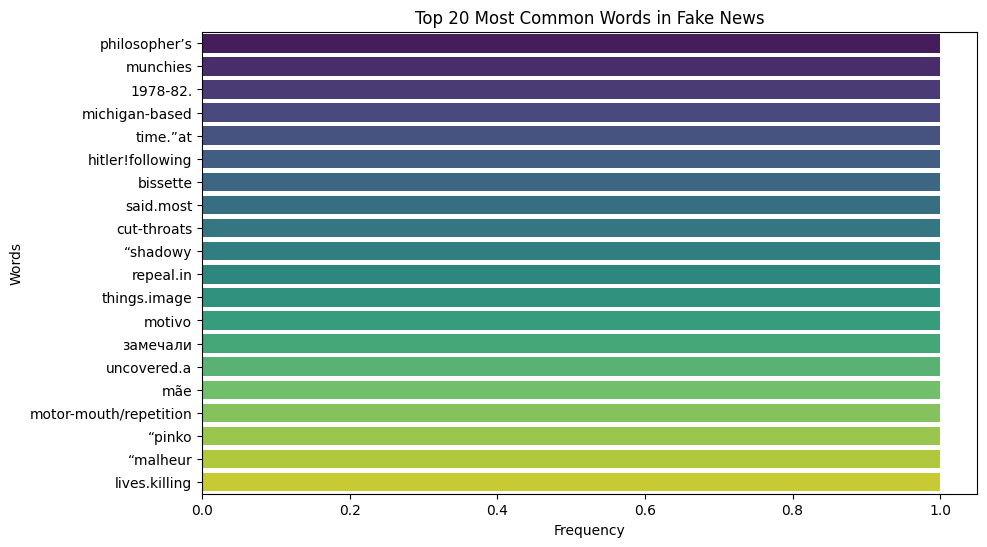

In [ ]:
fake_word_freq = Counter(fake_words)
most_common_fake = fake_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_fake], y=[word[0] for word in most_common_fake], palette = "viridis")
plt.title('Top 20 Most Common Words in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

/tmp/ipython-input-52-3644164906.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in most_common_shared], y=[word[0] for word in most_common_shared], palette = "viridis")


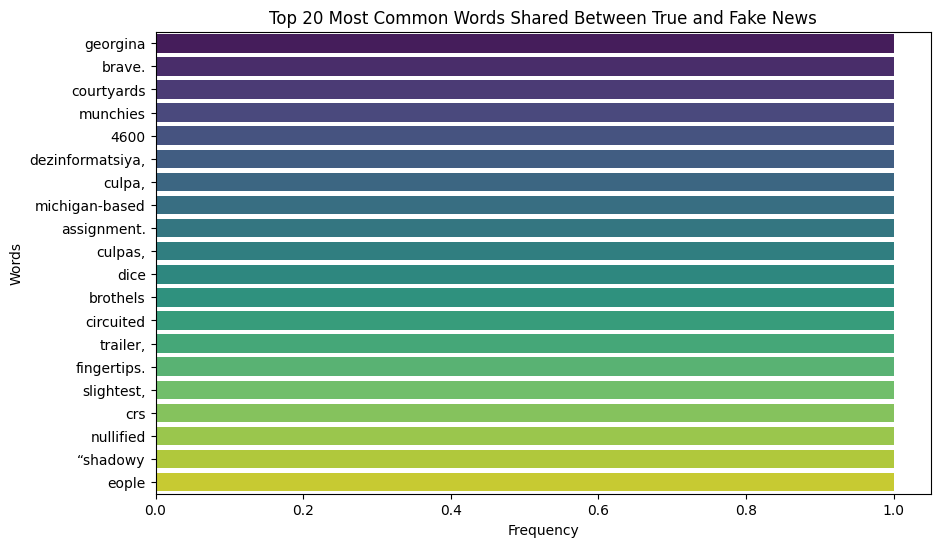

In [ ]:
common_word_freq = Counter(common_words)
most_common_shared = common_word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_shared], y=[word[0] for word in most_common_shared], palette = "viridis")
plt.title('Top 20 Most Common Words Shared Between True and Fake News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

### Word Cloud

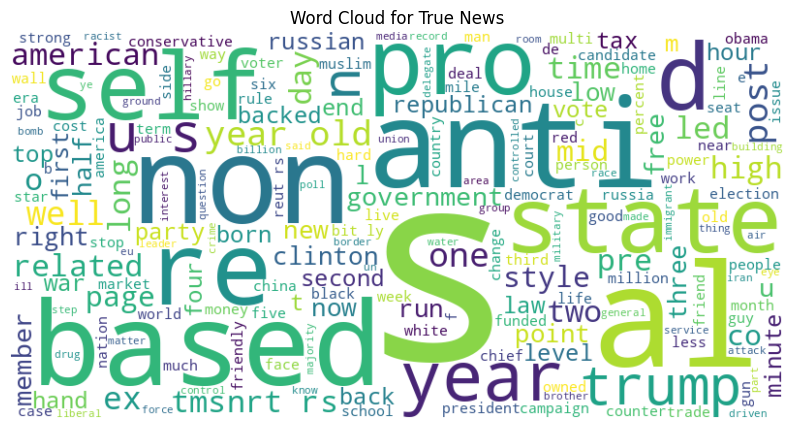

In [ ]:
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(true_words))

plt.figure(figsize=(10, 6))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')
plt.show()

Words such as `state`, `based`, `non`, `self`, `anti`, `pro`, `year`, and `trump` appear prominently with high frequency. This indicates that articles labeled as True News primarily revolve around topics related to current affairs, politics, and public policy. The presence of prefixes like *non-*, *self-*, and *anti-* reflects expressions of opinions, attributes, or stances — which are typical in factual news reporting.

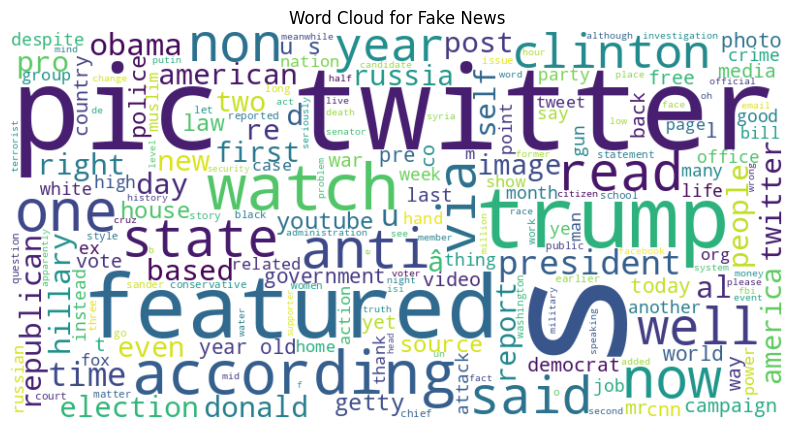

In [ ]:
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(fake_words))

plt.figure(figsize=(10, 6))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()

The most frequently occurring words in the Fake News dataset include `pic`, `twitter`, `featured`, `watch`, `according`, `trump`, and `said`. The content often relates to social media, images, and clickbait-style headlines, but still revolves around political topics, similar to True News.

## n-grams

In [ ]:
def get_top_n_grams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

/tmp/ipython-input-78-3771133564.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_positive_unigrams], y=[word[0] for word in top_positive_unigrams], palette = "viridis")


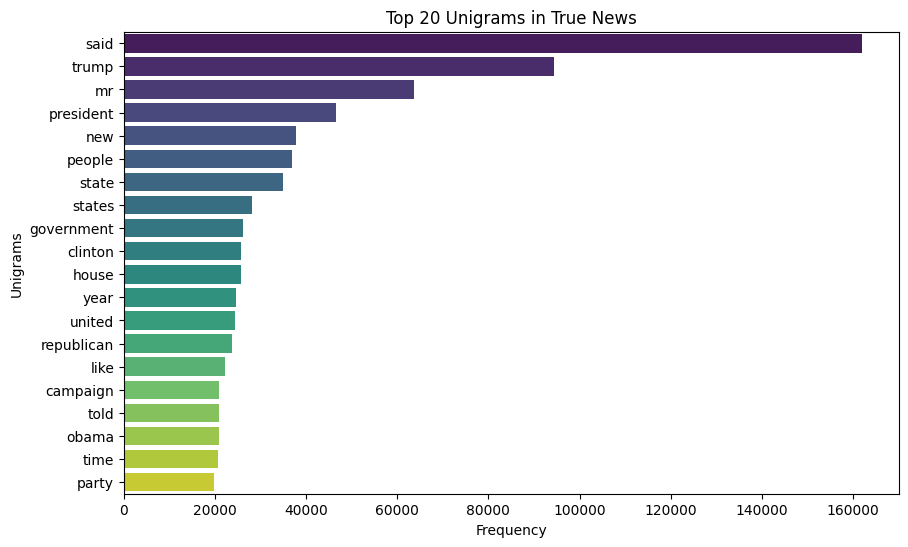

/tmp/ipython-input-78-3771133564.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_negative_unigrams], y=[word[0] for word in top_negative_unigrams], palette = "viridis")


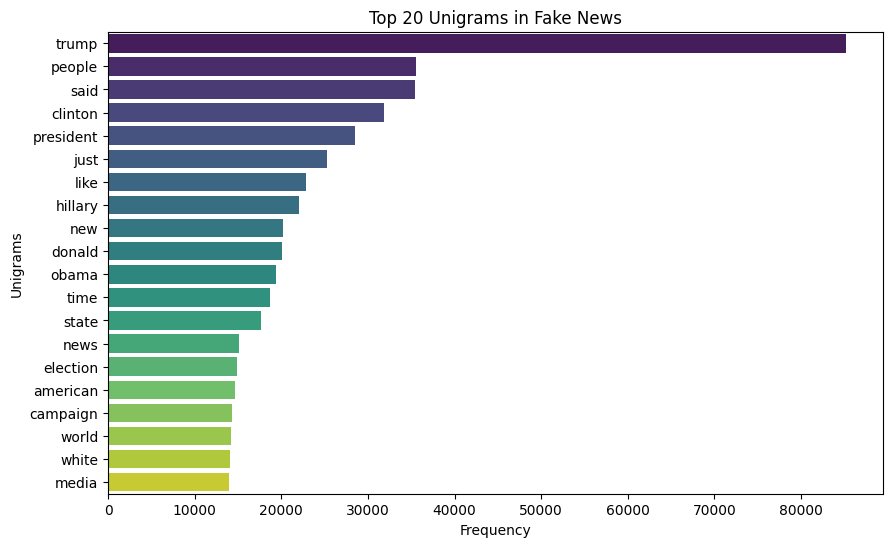

In [ ]:
top_positive_unigrams = get_top_n_grams(df[df['label'] == 1]['clean_text'], ngram_range=(1, 1), n=20)
top_negative_unigrams = get_top_n_grams(df[df['label'] == 0]['clean_text'], ngram_range=(1, 1), n=20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_positive_unigrams], y=[word[0] for word in top_positive_unigrams], palette = "viridis")
plt.title('Top 20 Unigrams in True News')
plt.xlabel('Frequency')
plt.ylabel('Unigrams')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_negative_unigrams], y=[word[0] for word in top_negative_unigrams], palette = "viridis")
plt.title('Top 20 Unigrams in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Unigrams')
plt.show()

In True News, the word `said` ranks highest in frequency (nearly 160,000), followed by `trump`, `mr`, `president`, and `new`, indicating a focus on official statements and political figures. In Fake News, `trump` tops the list with a significantly high frequency (around 80,000), followed by `people`, `said`, `clinton` and `president`, reflecting an emphasis on political figures and the general public.

Overall, True News exhibits higher word frequencies (up to 160,000), while Fake News has a lower frequency range (maximum 80,000), but features a more diverse word set, including terms like `election` and `world`.

### Bigrams

/tmp/ipython-input-79-4263926821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_positive_bigrams], y=[word[0] for word in top_positive_bigrams], palette = "viridis")


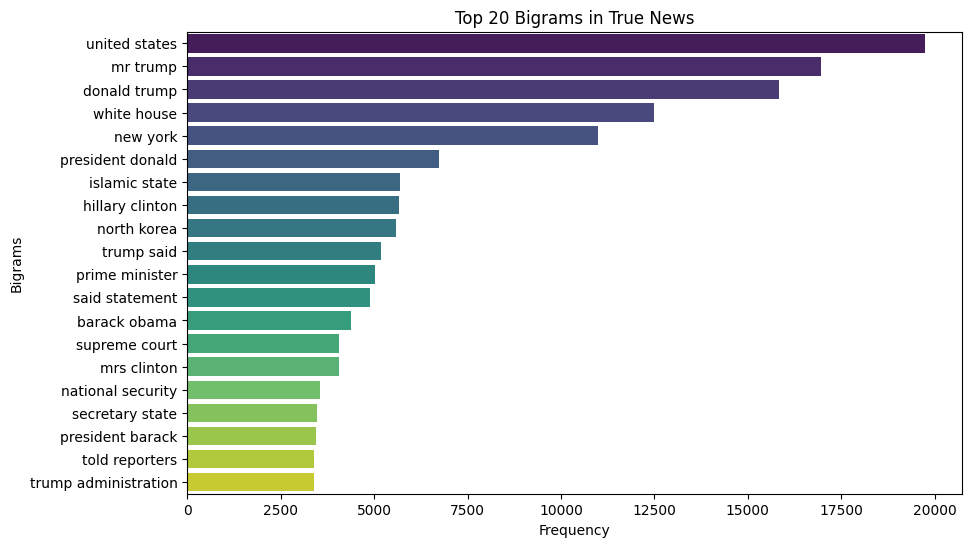

/tmp/ipython-input-79-4263926821.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in top_negative_bigrams], y=[word[0] for word in top_negative_bigrams], palette = "viridis")


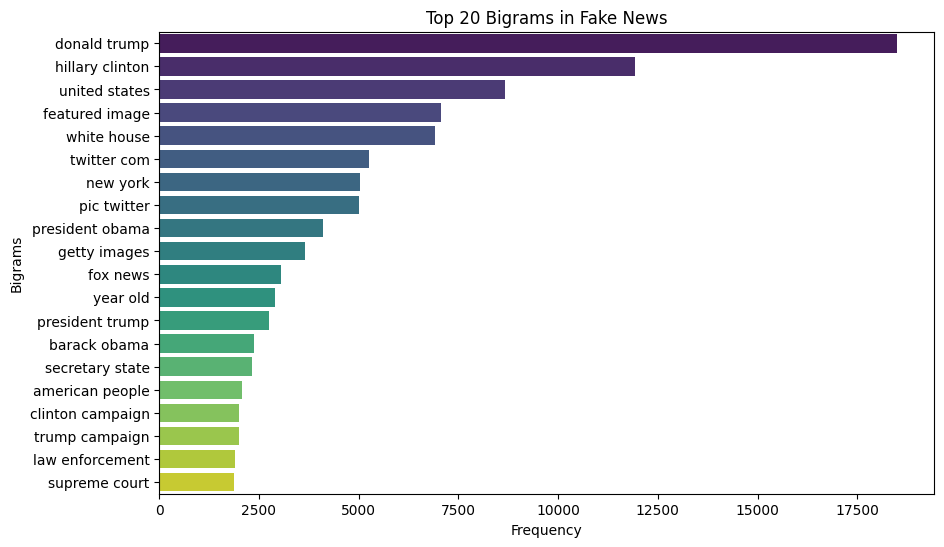

In [ ]:
top_positive_bigrams = get_top_n_grams(df[df['label'] == 1]['clean_text'], ngram_range=(2, 2), n=20)
top_negative_bigrams = get_top_n_grams(df[df['label'] == 0]['clean_text'], ngram_range=(2, 2), n=20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_positive_bigrams], y=[word[0] for word in top_positive_bigrams], palette = "viridis")
plt.title('Top 20 Bigrams in True News')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in top_negative_bigrams], y=[word[0] for word in top_negative_bigrams], palette = "viridis")
plt.title('Top 20 Bigrams in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

Both contain prominent appearances of `trump`, `clinton`, and `united states`, but True News is more focused on formal terms (such as `prime minister`, `supreme court`) with a steady frequency decline, whereas Fake News includes additional media-related words (like `twitter com`, `pic twitter`) and image references (such as `featured image`, `getty images`), highlighting a difference in style and information sources.

## TF-IDF

/tmp/ipython-input-80-3266650787.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=true_top_words.values, y=true_top_words.index, palette = "viridis")


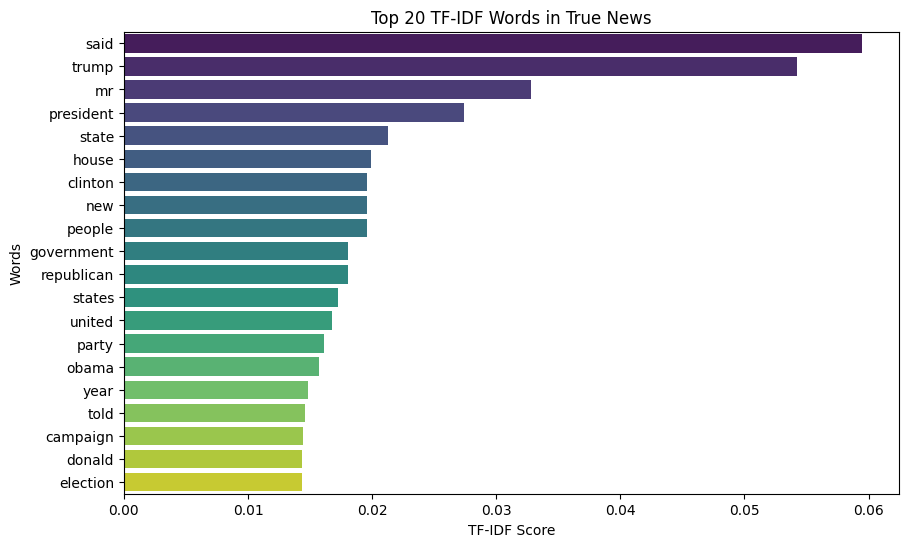

In [ ]:
true_reviews = df[df['label'] == 1]['clean_text']
tfidf_vectorizer_true = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_true = tfidf_vectorizer_true.fit_transform(true_reviews)
true_top_words = pd.DataFrame(tfidf_true.toarray(), columns=tfidf_vectorizer_true.get_feature_names_out()).mean().sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=true_top_words.values, y=true_top_words.index, palette = "viridis")
plt.title('Top 20 TF-IDF Words in True News')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

/tmp/ipython-input-81-971271306.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fake_top_words.values, y=fake_top_words.index, palette = "viridis")


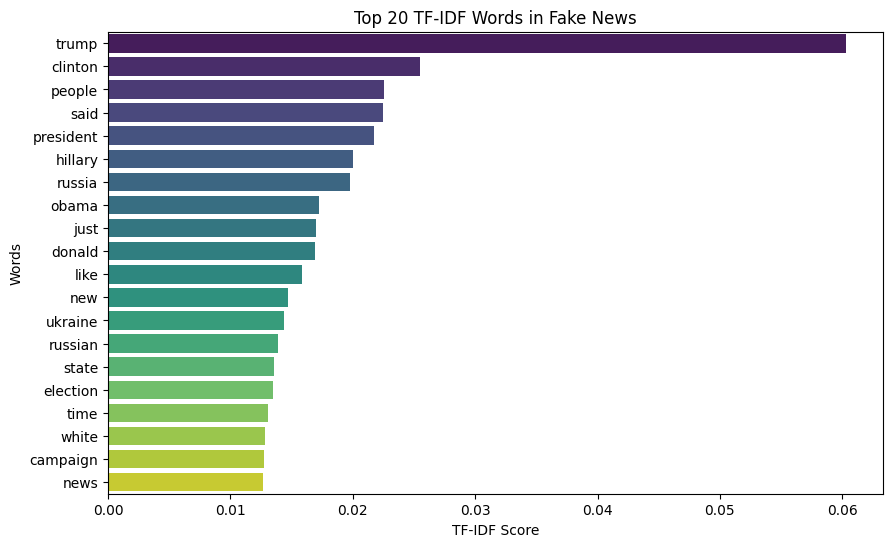

In [ ]:
fake_reviews = df[df['label'] == 0]['clean_text']
tfidf_vectorizer_fake = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_fake = tfidf_vectorizer_fake.fit_transform(fake_reviews)
fake_top_words = pd.DataFrame(tfidf_fake.toarray(), columns=tfidf_vectorizer_fake.get_feature_names_out()).mean().sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=fake_top_words.values, y=fake_top_words.index, palette = "viridis")
plt.title('Top 20 TF-IDF Words in Fake News')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

Both show strong occurrences of `trump`, `clinton`, `president`, and `said`, but True News emphasizes administrative terms (such as `government`, `state`) with a steadily decreasing TF-IDF score, while Fake News highlights words like `hillary`, `obama`, and `russia`, suggesting a focus on specific individuals and events.

## Textual Feature Distribution Analysis

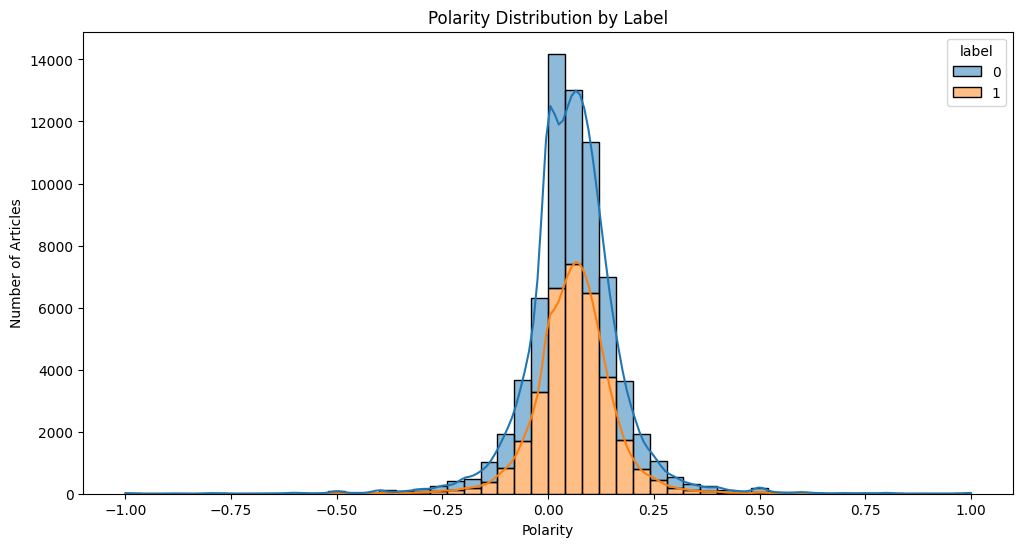

In [ ]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['polarity'] = df['clean_text'].apply(get_polarity)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='polarity', hue='label', multiple='stack', bins=50, kde=True)
plt.title('Polarity Distribution by Label')
plt.xlabel('Polarity')
plt.ylabel('Number of Articles')
plt.show()

The distribution of both labels (0 and 1) is mainly concentrated around a Polarity value close to 0. There are very few articles with extreme Polarity (below -0.5 or above 0.5), indicating that most articles exhibit a moderate level of positivity or negativity.

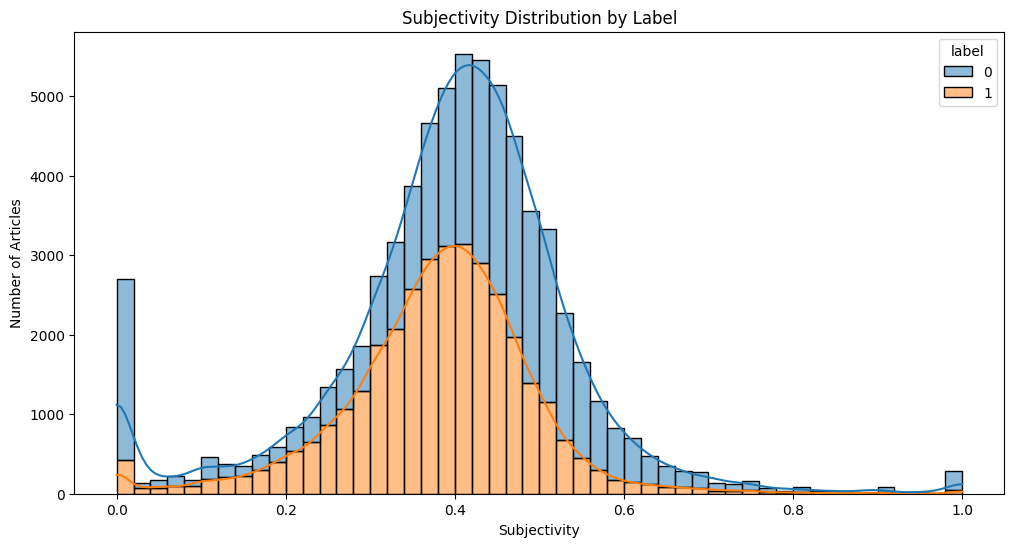

In [ ]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df['subjectivity'] = df['clean_text'].apply(get_subjectivity)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='subjectivity', hue='label', multiple='stack', bins=50, kde=True)
plt.title('Subjectivity Distribution by Label')
plt.xlabel('Subjectivity')
plt.ylabel('Number of Articles')
plt.show()

Both labels (0 - Fake News and 1 - True News) have distributions mainly concentrated in the subjectivity range of 0.2 to 0.6. Very few articles have subjectivity > 0.6, indicating that both types of news tend to remain neutral and not emotionally biased. However, label 1 appears to be more objective compared to label 0.

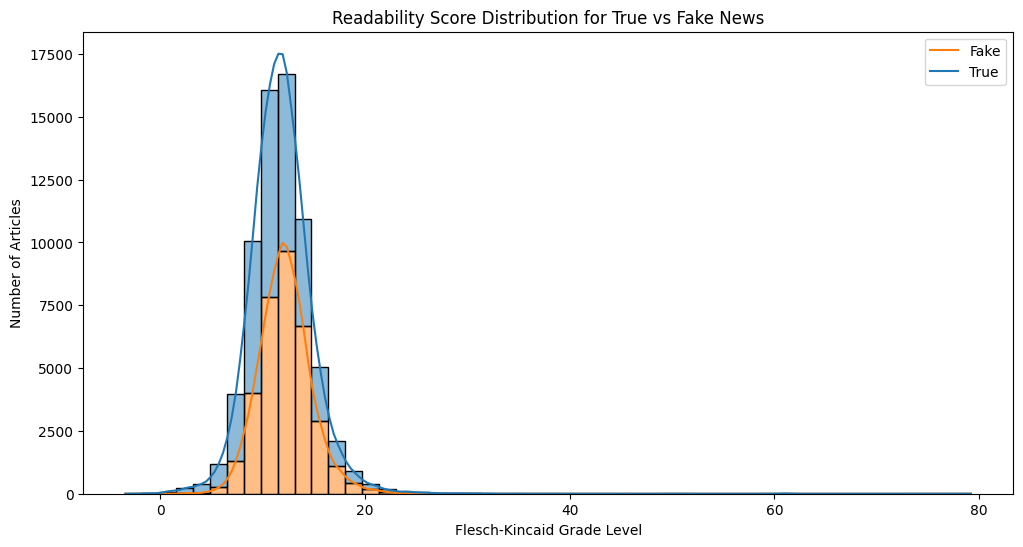

In [ ]:
def get_flesch_kincaid(text):
    return textstat.flesch_kincaid_grade(text)

df['readability_score'] = df['clean_text'].apply(get_flesch_kincaid)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='readability_score', hue='label', multiple='stack', bins=50, kde=True)
plt.title('Readability Score Distribution for True vs Fake News')
plt.xlabel('Flesch-Kincaid Grade Level')
plt.ylabel('Number of Articles')
plt.legend(labels=['Fake', 'True'])
plt.show()

The distribution of both true news (label 1) and fake news (label 0) is primarily concentrated within the Flesch-Kincaid Grade Level range of 5 to 20, indicating that the content is generally targeted at readers with basic to intermediate reading skills. The number of articles drops sharply beyond a score of 20, suggesting that both types of news are written at a readable level, without being overly academic or complex.

## Punctuation Analysis

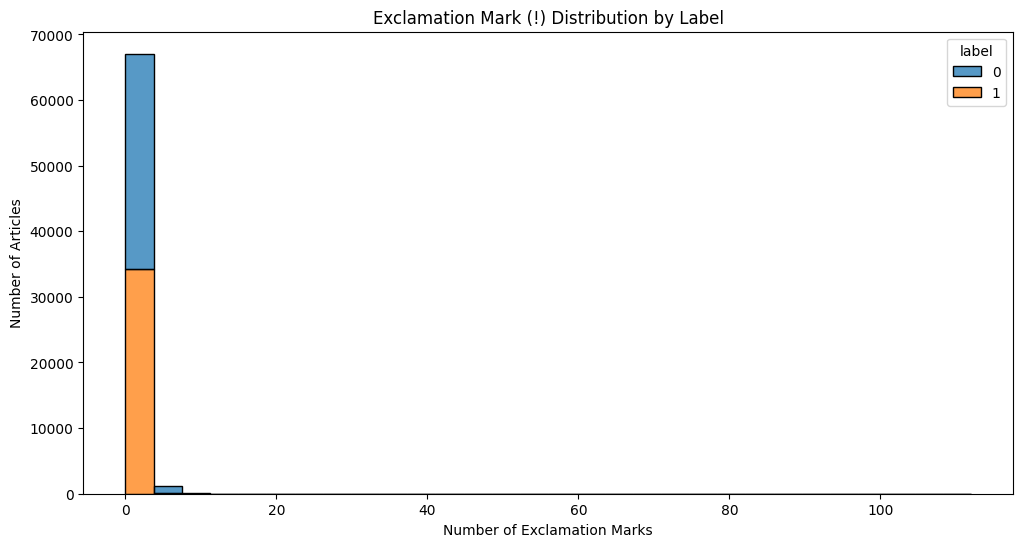

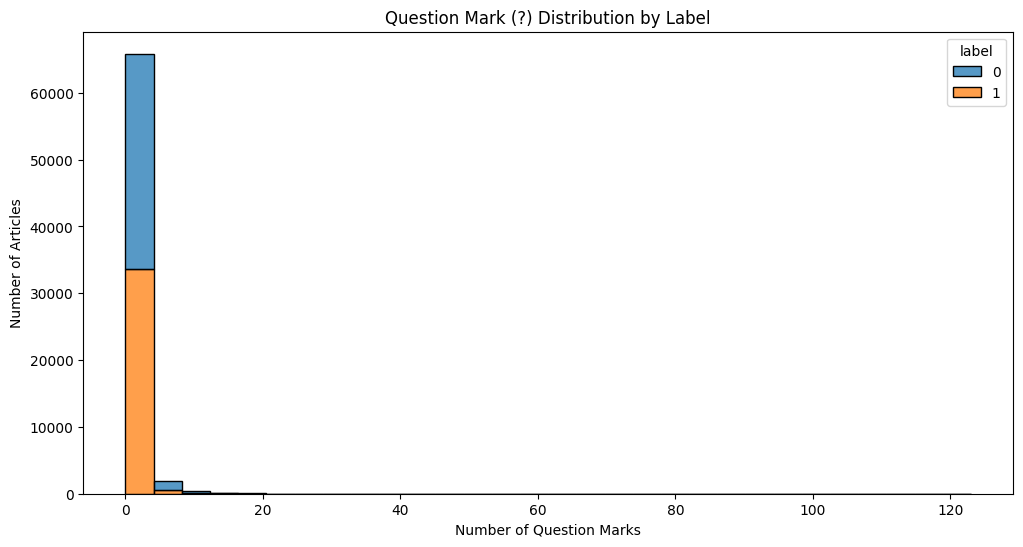

In [ ]:
def count_punctuation(text, punct):
    return text.count(punct)

df['exclamation_count'] = df['clean_text'].apply(lambda x: count_punctuation(x, '!'))
df['question_count'] = df['clean_text'].apply(lambda x: count_punctuation(x, '?'))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='exclamation_count', hue='label', multiple='stack', bins=30)
plt.title('Exclamation Mark (!) Distribution by Label')
plt.xlabel('Number of Exclamation Marks')
plt.ylabel('Number of Articles')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='question_count', hue='label', multiple='stack', bins=30)
plt.title('Question Mark (?) Distribution by Label')
plt.xlabel('Number of Question Marks')
plt.ylabel('Number of Articles')
plt.show()

Both types of news (True News and Fake News) rarely use punctuation marks (`!` and `?`). However, Fake News tends to use these marks more frequently in the range of 2–5 times, reflecting a sensational style and an attempt to persuade through emotion – a typical characteristic of fake news.

## Keep only the necessary columns

In [ ]:
df = df[['text', 'label', 'clean_text']]

# Model building

## Set common parameters

In [35]:
RANDOM_STATE = 42
patience = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train-test split

In [36]:
X = df['clean_text'].tolist()
y = df['label'].tolist()

- Split the dataset into training, validation, and test sets with respective ratios of 70%, 15%, and 15%.

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=df['label'])

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

- Count the number of labels

In [ ]:
print("Train label distribution:", Counter(y_train))
print("Validation label distribution:", Counter(y_val))
print("Test label distribution:", Counter(y_test))

Train label distribution: Counter({1: 24161, 0: 23742})
Validation label distribution: Counter({1: 5178, 0: 5087})
Test label distribution: Counter({1: 5178, 0: 5088})


## Evaluation Functions

- Classification Report & Confusion Matrix

In [38]:
def evaluate(y_true, y_pred):
  label_description = {"0": "Fake News", "1": "True News"}
  print("Classification report: \n", classification_report(y_true , y_pred))

  print("Confusion matrix: \n")
  conf_matrix = confusion_matrix(y_true , y_pred)
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_description.values()), yticklabels=list(label_description.values()))
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('Confusion Matrix')
  plt.show()

- Training Curves

In [39]:
def plot_curves(train_loss, val_loss, val_acc, title="Learning Curve"):
    epochs = range(1, len(train_loss) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss
    axes[0].plot(epochs, train_loss, label="Train loss")
    axes[0].plot(epochs, val_loss,   label="Val loss")
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss"); axes[0].legend(); axes[0].grid(ls="--", alpha=.4)

    # Val accuracy
    axes[1].plot(epochs, val_acc, label="Val acc", color="tab:orange")
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Validation accuracy")
    axes[1].legend(); axes[1].grid(ls="--", alpha=.4)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

- ROC Curve

In [40]:
def plot_roc_curve(y_true, y_score, pos_label=1, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(fpr, tpr, color="tab:red",
            label=f"User model (AUC = {roc_auc:.2f})", lw=2)

    # random
    ax.plot([0, 1], [0, 1], "k--", lw=2)  # Đường chéo

    # perfect
    ax.plot([0, 0, 1], [0, 1, 1], color="green",
            label="Perfect model", lw=1)

    ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.02])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3, ls="--")

    plt.show()

    return ax

## Build model

### Machine Learning Model

In [ ]:
def build_ml_model(X, y):
    model = Pipeline([
        ("tfidf", TfidfVectorizer(
            tokenizer=tokenize_and_filter,
            lowercase=False,
            preprocessor=None,
            token_pattern=None,
            ngram_range=(1, 2)
        )),
        ("svc", LinearSVC())
    ])

    model.fit(X, y)

    return model

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      5087
           1       0.95      0.95      0.95      5178

    accuracy                           0.95     10265
   macro avg       0.95      0.95      0.95     10265
weighted avg       0.95      0.95      0.95     10265

Confusion matrix: 



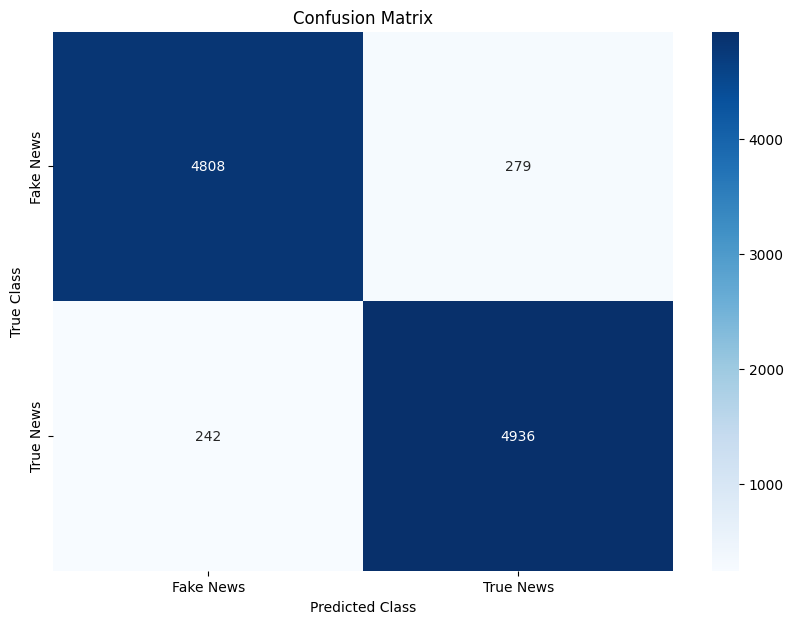

In [ ]:
model = build_ml_model(X_train, y_train)

pred = model.predict(X_val)
evaluate(y_val, pred)

#### Hyperparameter Tuning for ML Model

In [ ]:
# Define the parameter grid
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_features": [None, 50_000],

    "svc__C":  [0.5, 1, 2],
}

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer      = tokenize_and_filter,
        min_df = 5,
        max_df = 0.9,
        lowercase      = False,
        preprocessor   = None,
        token_pattern  = None
    )),
    ("svc",  LinearSVC(random_state=RANDOM_STATE))
])

# Set up GridSearchCV
gridsearch = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1", verbose=3, n_jobs=-1)

# Find the best hyperparameters
gridsearch.fit(X_train, y_train)

# Print the best hyperparameters found and the best cross-validation score
print("Best Parameters:", gridsearch.best_params_)
print("Best Cross-Validation Score:", gridsearch.best_score_)

# Save the fitted GridSearchCV object to a pkl file
with open('best_svm.pkl', 'wb') as file:
    pickle.dump(gridsearch, file)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'svc__C': 2, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Score: 0.9494083910753494


- Load best model

In [ ]:
# Load the GridSearchCV object from the pickle file
with open('best_svm.pkl', 'rb') as file:
    loaded_gridsearch = pickle.load(file)

print("Best Parameters:", loaded_gridsearch.best_params_)
best_model = loaded_gridsearch.best_estimator_

Best Parameters: {'svc__C': 2, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}


- Evaluation

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      5088
           1       0.96      0.95      0.95      5178

    accuracy                           0.95     10266
   macro avg       0.95      0.95      0.95     10266
weighted avg       0.95      0.95      0.95     10266

Confusion matrix: 



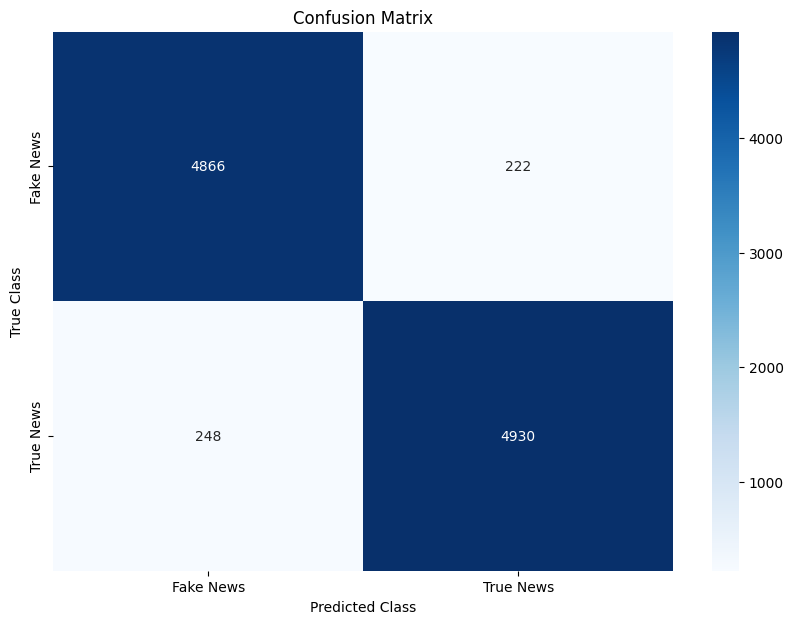

In [ ]:
y_pred = best_model.predict(X_test)
evaluate(y_test, y_pred)

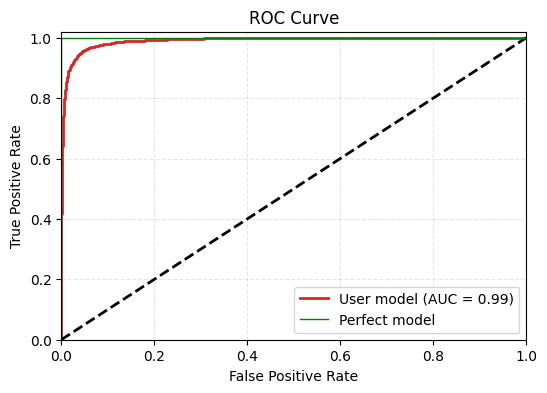

<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
y_score = best_model.decision_function(X_test)
plot_roc_curve(y_test, y_score)

### Baseline Deep Learning Model

In [41]:
# Tokenization
# Fit tokenizer on training data
tokenizer = Tokenizer(num_words=5000) # keep the 5000 most frequent words
tokenizer.fit_on_texts(X_train)
# Convert texts to sequences and apply padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=512, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=512, padding='post', truncating='post')

# Convert to tensor
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Dataset & DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TextDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Multilevel-CNN

**Architecture:**

Input (text sequence) 

→ Embedding Layer 

→ Conv1D (kernel size 3) → GlobalMaxPool 

→ Conv1D (kernel size 4) → GlobalMaxPool 

→ Conv1D (kernel size 5) → GlobalMaxPool 

→ Concatenate 

→ Dense layers 

→ Dropout

→ Output (Sigmoid)

- Define the model

In [ ]:
class MultilevelCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, num_classes=1):
        super(MultilevelCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) # Embedding layer
        self.conv3 = nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=4)
        self.conv5 = nn.Conv1d(in_channels=embed_dim, out_channels=32, kernel_size=5)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(32*3, 10)  # Fully connected layer
        self.out = nn.Linear(10, num_classes)  # Output layer

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.permute(0, 2, 1) # (batch_size, embed_dim, seq_len)

        x1 = F.relu(self.conv3(x))  # Conv1D with kernel size 3
        x2 = F.relu(self.conv4(x))  # Conv1D with kernel size 4
        x3 = F.relu(self.conv5(x))  # Conv1D with kernel size 5

        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2) # Global Max Pooling
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = F.max_pool1d(x3, x3.size(2)).squeeze(2)

        x = torch.cat((x1, x2, x3), 1) # Concatenate
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x)) # Binary classification
        return x

- Training Configuration

In [ ]:
model = MultilevelCNN(vocab_size=5000).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
wait = 0
num_epochs = 20

- Training Loop

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=True)
    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze(1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation after each epoch
    model.eval()
    correct, val_loss_total, total = 0, 0, 0
    val_loop = tqdm(test_loader, desc=f"Epoch {epoch+1} [Val]", leave=True)
    with torch.no_grad():
        for batch_X, batch_y in val_loop:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze(-1)
            val_loss = criterion(outputs, batch_y)
            val_loss_total += val_loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
            val_loop.set_postfix(val_loss=val_loss.item())

    # Calculate average value
    train_loss_avg = train_loss / len(test_loader)
    val_loss_avg = val_loss_total / len(test_loader)
    val_acc = correct / total

    # Save value into list
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_acc)


    print(f"Epoch {epoch+1} | Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Early stopping check
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        wait = 0
        torch.save(model.state_dict(), "best_multilevelcnn_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Save training logs to CSV
log_df = pd.DataFrame({
    "epoch": list(range(1, len(train_losses)+1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_accuracy": val_accuracies
})
log_df.to_csv("training_multilevelcnn.csv", index=False)

- Prediction Function

In [ ]:
def predict_text(texts):
    model.eval()
    seq = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seq, maxlen=512, padding='post', truncating='post')
    tensor = torch.tensor(padded, dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = model(tensor)
        probs = outputs.cpu().numpy()
        return probs, (probs > 0.5).astype(int)

- Load and Evaluate Model from Checkpoint

In [42]:
def load_and_evaluate(model_name, pt_path, csv_path, X_test_tensor, y_test_tensor):
    # Load model
    model = model_name(vocab_size=5000).to(device)
    model.load_state_dict(torch.load(pt_path, map_location=device))
    model.eval()

    # Predict on test set
    with torch.no_grad():
        y_score = model(X_test_tensor).squeeze(-1).cpu().numpy()
        y_pred = (y_score > 0.5).astype(int)

    # Evaluate
    evaluate(y_test_tensor.cpu().numpy(), y_pred)

    # Plot ROC
    plot_roc_curve(y_test_tensor.cpu().numpy(), y_score)

    # Plot training curves
    logs = pd.read_csv(csv_path)
    plot_curves(logs['train_loss'], logs['val_loss'], logs['val_accuracy'])

Classification report: 
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5088
         1.0       0.96      0.96      0.96      5178

    accuracy                           0.96     10266
   macro avg       0.96      0.96      0.96     10266
weighted avg       0.96      0.96      0.96     10266

Confusion matrix: 



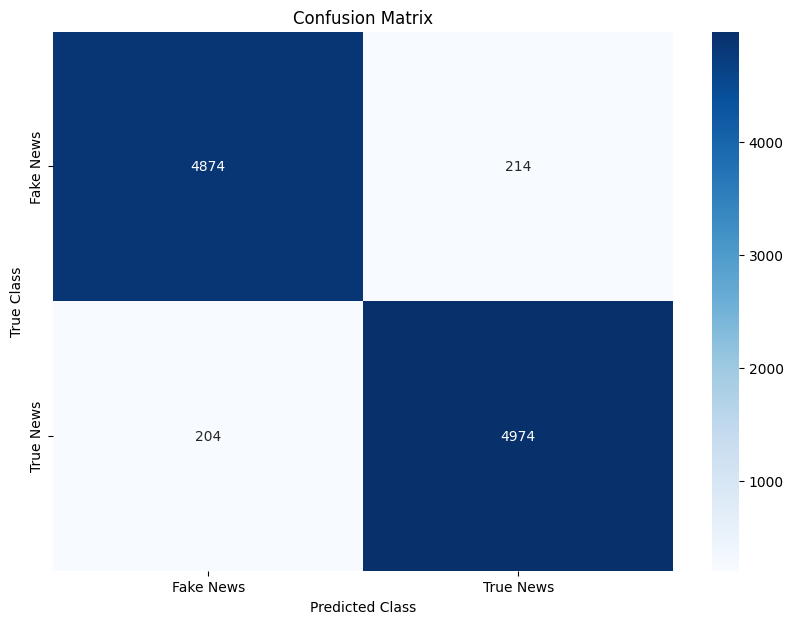

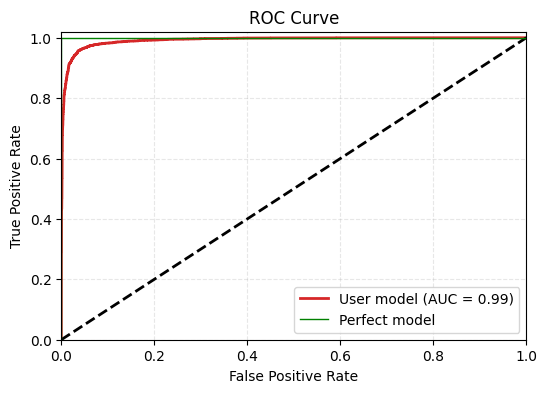

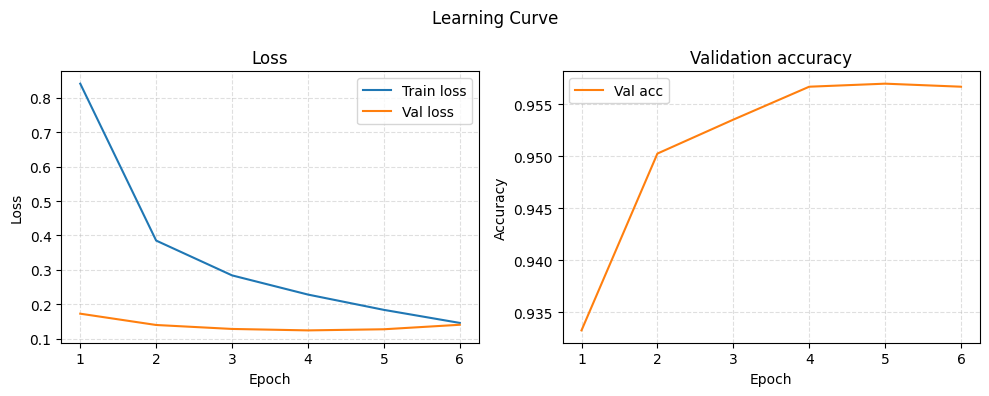

In [ ]:
load_and_evaluate(
    model_name=MultilevelCNN,
    pt_path="best_multilevelcnn_model.pt",
    csv_path="training_multilevelcnn.csv",
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor
)

#### CNN + BiLSTM

**Architecture:**

Input (text sequence) 

→ Embedding Layer 

→ Conv1D 

→ ReLU 

→ BiLSTM (take last hidden state) 

→ Dense 

→ ReLU 

→ Dropout 

→ Output (Sigmoid)


- Define the model

In [43]:
class CNNBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128):
        super(CNNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=5, padding=2)
        self.bilstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim*2, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.bilstm(x)
        x = lstm_out[:, -1, :]  # hidden cuối
        x = self.dropout(F.relu(self.fc(x)))
        x = torch.sigmoid(self.out(x)).squeeze(1)
        return x

- Training Configuration

In [ ]:
model = CNNBiLSTM(vocab_size=5000).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience = 2
wait = 0
num_epochs = 20

- Training Loop

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=True)
    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
        loop.set_postfix(loss=loss.item())

    # Validation after each epoch
    model.eval()
    correct, val_loss_total, total = 0, 0, 0
    val_loop = tqdm(test_loader, desc=f"Epoch {epoch+1} [Val]", leave=True)
    with torch.no_grad():
        for batch_X, batch_y in val_loop:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze(-1)
            val_loss = criterion(outputs, batch_y)
            val_loss_total += val_loss.item() * batch_X.size(0)

            preds = (outputs > 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
            val_loop.set_postfix(val_loss=val_loss.item())

    # Calculate average value
    train_loss_avg = train_loss / len(test_loader.dataset)
    val_loss_avg = val_loss_total / len(test_loader.dataset)
    val_acc = correct / total

    # Save value into list
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Early stopping check
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        wait = 0
        torch.save(model.state_dict(), "best_cnn_bilstm_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Save training logs to CSV
log_df = pd.DataFrame({
    "epoch": list(range(1, len(train_losses)+1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_accuracy": val_accuracies
})
log_df.to_csv("training_cnn_bilstm.csv", index=False)

- Load and Evaluate Model from Checkpoint

Classification report: 
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      5088
         1.0       0.97      0.97      0.97      5178

    accuracy                           0.97     10266
   macro avg       0.97      0.97      0.97     10266
weighted avg       0.97      0.97      0.97     10266

Confusion matrix: 



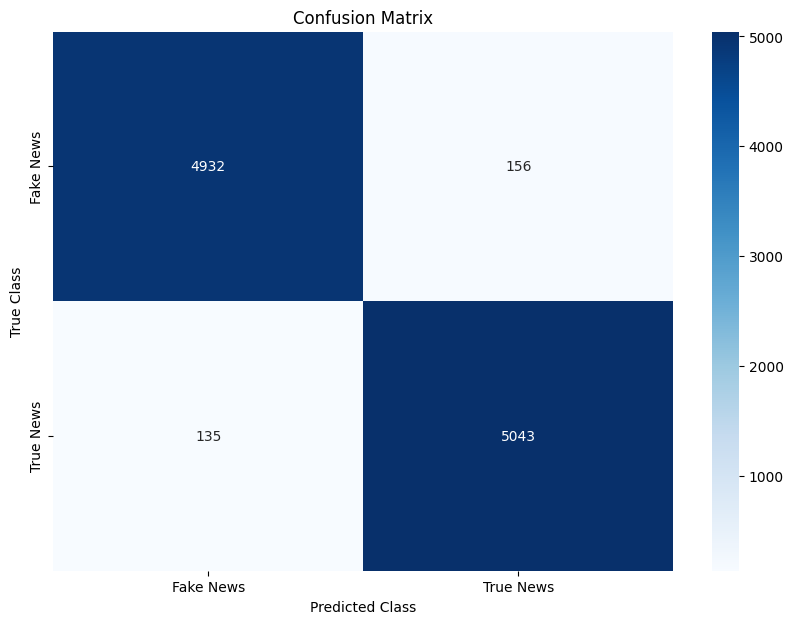

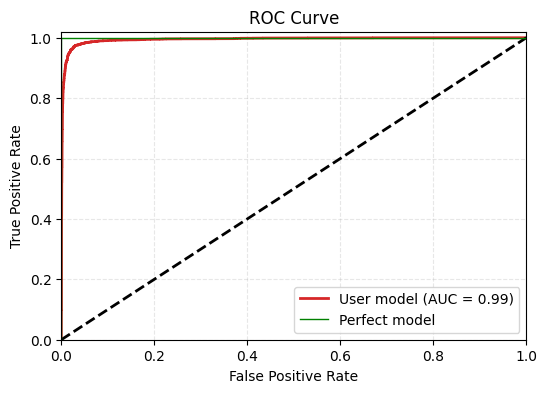

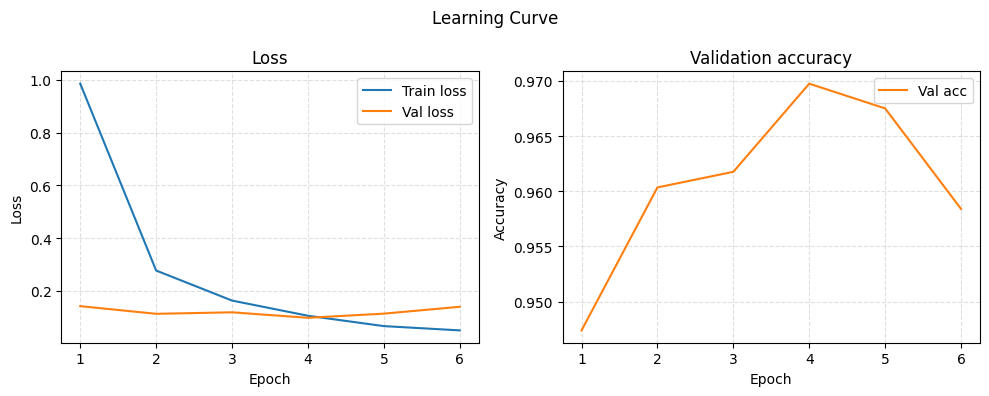

In [44]:
load_and_evaluate(
    model_name=CNNBiLSTM,
    pt_path="/kaggle/input/cnn-bilstm/best_cnn_bilstm_model.pt",
    csv_path="/kaggle/input/cnn-bilstm/training_cnn_bilstm.csv",
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor
)

### Deep Learning Model

- Training Configuration

In [20]:
learning_rate = 2e-5
epochs = 5

- Pretrained Model & Tokenizer

In [21]:
def get_tokenizer_and_model(model_name: str, num_labels: int):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    return tokenizer, model

- Dataset

In [22]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

- Dataloader

In [23]:
class DataLoaderBuilder:
    def __init__(self, dataset, batch_size=32, shuffle=True, num_workers=2):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def get_dataloader(self):
        return DataLoader(
            dataset=self.dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers
        )

In [24]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, model_name, lr=2e-5, epochs=5, patience=2, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.model_name = model_name
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.device = device
        self.optimizer = AdamW(self.model.parameters(), lr=lr)
        self.scheduler = get_scheduler("linear", self.optimizer, num_warmup_steps=0,
                                       num_training_steps=len(train_loader) * epochs)

        # Track training history
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        for batch in tqdm(self.train_loader, desc="Training"):
            batch = {k: v.to(self.device) for k, v in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        all_preds, all_labels = [], []
        total_loss = 0
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validating"):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                total_loss += loss.item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        avg_loss = total_loss / len(self.val_loader)
        return acc, avg_loss, all_preds, all_labels

    def train(self):
        best_loss = float('inf')
        stop_count = 0
        save_path = f"{self.model_name}_best.pt"

        for epoch in range(1, self.epochs + 1):
            print(f"\nEpoch {epoch}/{self.epochs}")
            train_loss = self.train_one_epoch()
            val_acc, val_loss, _, _ = self.evaluate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss:   {val_loss:.4f} | Accuracy: {val_acc:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                stop_count = 0
                torch.save(self.model.state_dict(), save_path)
            else:
                stop_count += 1
                if stop_count >= self.patience:
                    print("Early stopping triggered.")
                    break

        # Reload best model
        self.model.load_state_dict(torch.load(save_path))

        # Save training history
        log_df = pd.DataFrame({
            "epoch": list(range(1, len(self.train_losses) + 1)),
            "train_loss": self.train_losses,
            "val_loss": self.val_losses,
            "val_acc": self.val_accuracies
        })
        log_df.to_csv(f"{self.model_name}_training_log.csv", index=False)
        print("Training log saved.")

        return self.train_losses, self.val_losses, self.val_accuracies

    def test_model(self, test_loader):
        """
        Evaluate the best saved model on the test set.
        """
        save_path = f"{self.model_name}_best.pt"
        self.model.load_state_dict(torch.load(save_path))
        self.model.eval()

        all_preds, all_labels, all_probs = [], [], []
        total_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Testing"):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                preds = torch.argmax(probs, dim=-1)

                total_loss += loss.item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        acc = accuracy_score(all_labels, all_preds)

        # Save results to CSV
        results_df = pd.DataFrame({
            "true_label": all_labels,
            "pred_label": all_preds,
            "prob_class1": all_probs
        })
        results_path = f"{self.model_name}_test_results.csv"
        results_df.to_csv(results_path, index=False)
        print(f"Test results saved to {results_path}")

        return acc, avg_loss, all_preds, all_labels, all_probs

In [ ]:
def run_model(model_name, batch_size):
    global df, learning_rate, epochs, patience, X_train, X_val, X_test, y_train, y_val, y_test

    print("========== LOAD TOKENIZER & MODEL ==========")
    tokenizer, model = get_tokenizer_and_model(model_name, num_labels=len(set(df["label"])))

    print("========== CREATE DATASETS ==========")
    train_dataset = TextClassificationDataset(X_train, y_train, tokenizer)
    val_dataset = TextClassificationDataset(X_val, y_val, tokenizer)
    test_dataset = TextClassificationDataset(X_test, y_test, tokenizer)

    print("========== CREATE DATALOADERS ==========")
    train_loader = DataLoaderBuilder(train_dataset, batch_size=batch_size, shuffle=True).get_dataloader()
    val_loader = DataLoaderBuilder(val_dataset, batch_size=batch_size, shuffle=False).get_dataloader()
    test_loader = DataLoaderBuilder(test_dataset, batch_size=batch_size, shuffle=False).get_dataloader()

    print("========== INITIALIZE TRAINER ==========")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        model_name=model_name,
        lr=learning_rate,
        epochs=epochs,
        patience=patience,
        device=device
    )

    print(f"\n{'-'*50}")
    print(f"\tTRAINING MODEL: {model_name}")
    print(f"{'-'*50}")
    train_losses, val_losses, val_accuracies = trainer.train()

    print(f"\n{'-'*50}")
    print(f"\tEVALUATION ON TEST SET")
    print(f"{'-'*50}")
    test_acc, test_loss, test_preds, test_true_labels, test_probs = trainer.test_model(test_loader)

    evaluate(test_true_labels, test_preds)

    print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "test_preds": test_preds,
        "test_labels": test_true_labels,
        "test_probs": test_probs
    }


#### Run model

In [ ]:
run_model(model_name="bert-base-uncased", batch_size=64)

In [ ]:
run_model(model_name="roberta-base", batch_size=64)

In [ ]:
run_model(model_name="xlnet-base-cased", batch_size=32)

#### Load and Evaluate Model from Checkpoint

In [31]:
def load_and_evaluate_transformers(result_csv_path, csv_path):
    # Load test results
    results = pd.read_csv(result_csv_path)
    true_labels = results["true_label"].values
    pred_labels = results["pred_label"].values
    prob_class1 = results["prob_class1"].values

    # Evaluate
    evaluate(true_labels, pred_labels)

    # Plot ROC
    plot_roc_curve(true_labels, prob_class1)

    # Plot training curves
    logs = pd.read_csv(csv_path)
    plot_curves(logs['train_loss'], logs['val_loss'], logs['val_acc'])

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5088
           1       0.99      0.97      0.98      5178

    accuracy                           0.98     10266
   macro avg       0.98      0.98      0.98     10266
weighted avg       0.98      0.98      0.98     10266

Confusion matrix: 



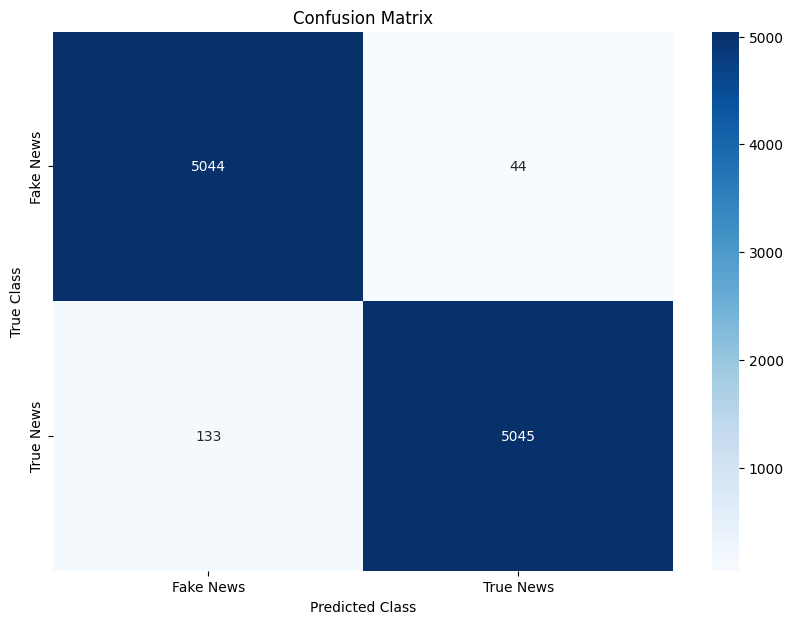

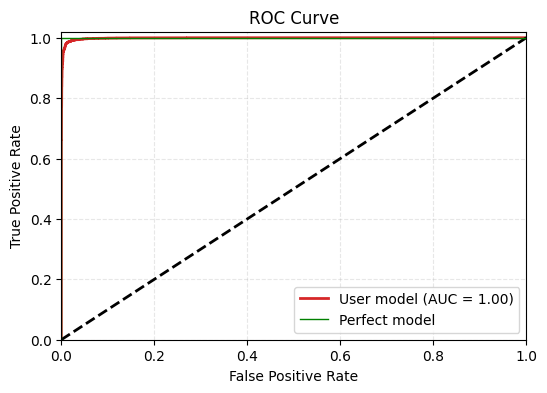

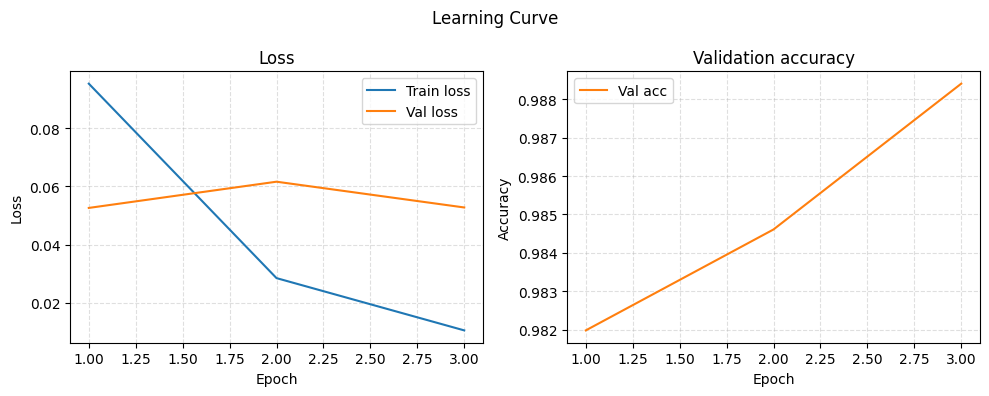

In [33]:
load_and_evaluate_transformers(
    result_csv_path="bert-base-uncased_test_results.csv",
    csv_path="bert-base-uncased_training_log.csv"
)

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5088
           1       0.99      0.99      0.99      5178

    accuracy                           0.99     10266
   macro avg       0.99      0.99      0.99     10266
weighted avg       0.99      0.99      0.99     10266

Confusion matrix: 



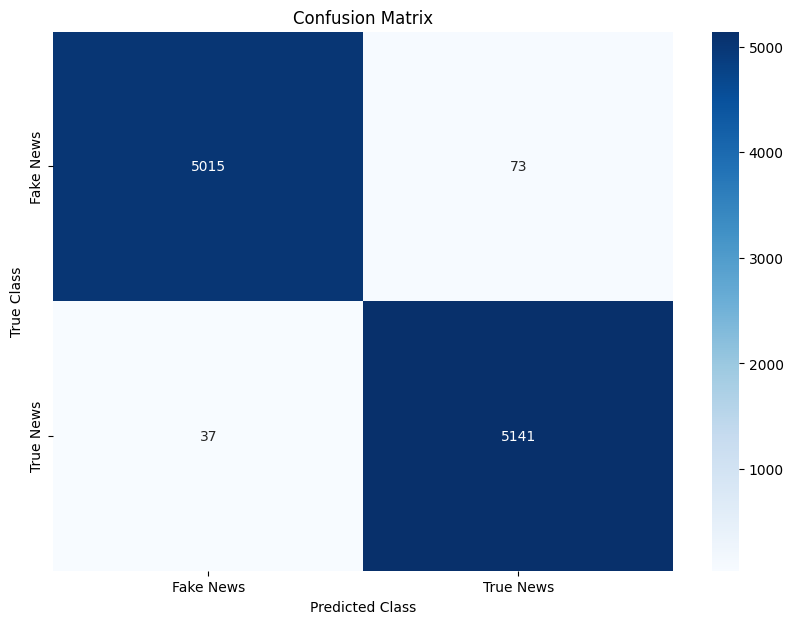

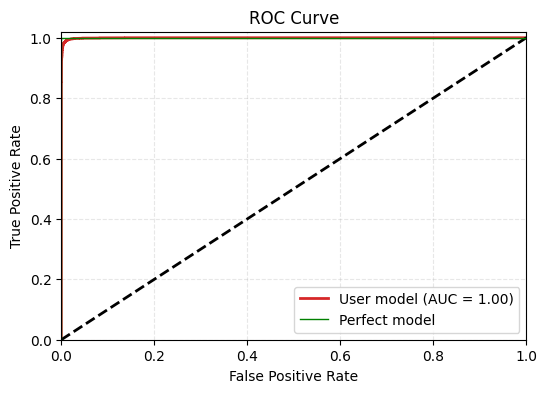

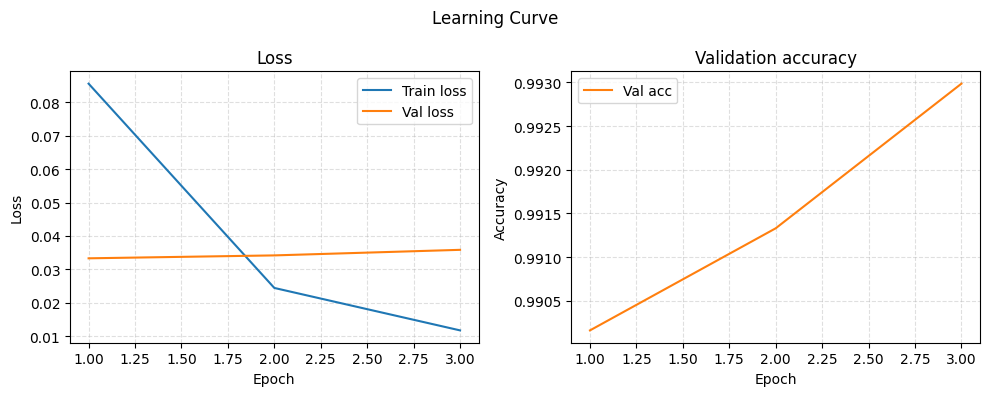

In [35]:
load_and_evaluate_transformers(
    result_csv_path="roberta-base_test_results.csv",
    csv_path="roberta-base_training_log.csv"
)

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5088
           1       0.99      0.99      0.99      5178

    accuracy                           0.99     10266
   macro avg       0.99      0.99      0.99     10266
weighted avg       0.99      0.99      0.99     10266

Confusion matrix: 



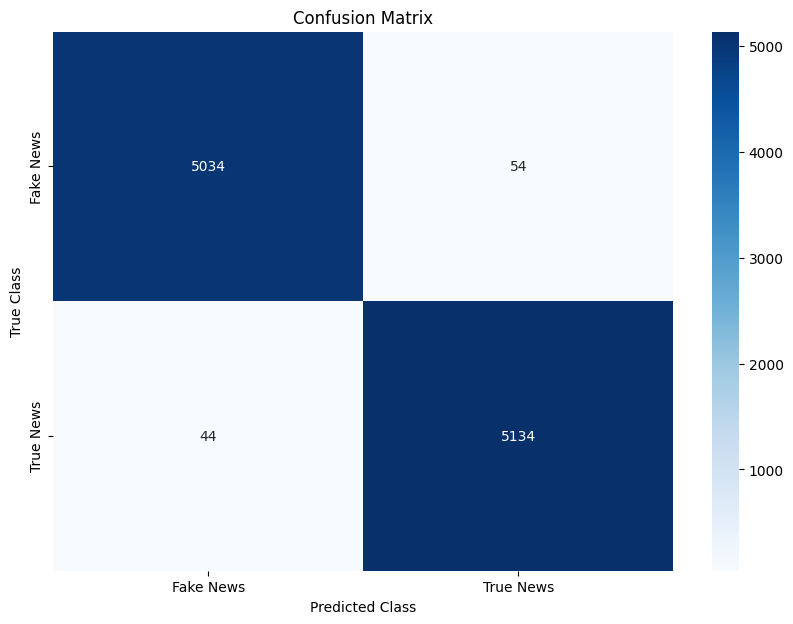

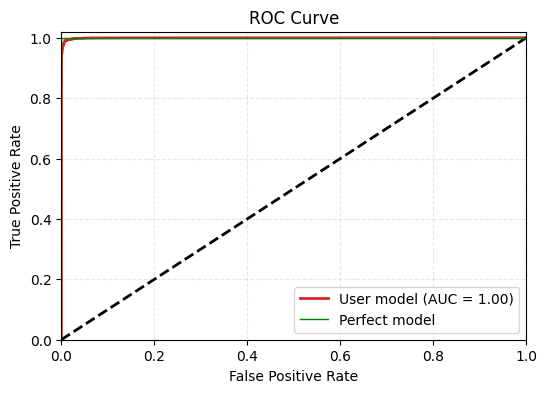

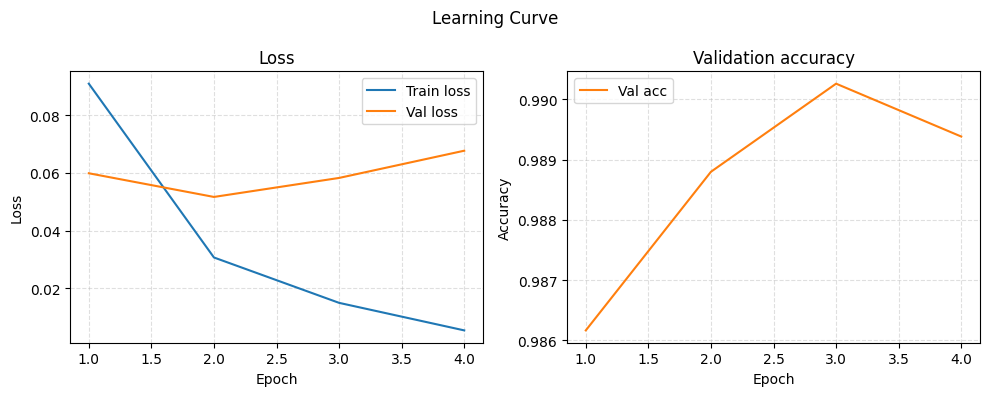

In [36]:
load_and_evaluate_transformers(
    result_csv_path="xlnet-base-cased_test_results.csv",
    csv_path="xlnet-base-cased_training_log.csv"
)

# Compare Models

| Model               | Accuracy | Precision | Recall | F1-score |
|---------------------|----------|-----------|--------|----------|
| TF-IDF + LinearSVM  | 0.95     | 0.95      | 0.95   | 0.95     |
| Multilevel-CNN      | 0.96     | 0.96      | 0.96   | 0.96     |
| CNN + BiLSTM        | 0.97     | 0.97      | 0.97   | 0.97     |
| BERT                | 0.98     | 0.98      | 0.98   | 0.98     |
| RoBERTa             | 0.99     | 0.99      | 0.99   | 0.99     |
| XLNet               | 0.99     | 0.99      | 0.99   | 0.99     |

Baseline deep learning models such as `Multilevel-CNN` and `CNN + BiLSTM` achieved solid results with accuracies of **0.96** and **0.97**, respectively, outperforming the traditional `TF-IDF + SVM` model (**0.95**). However, they still fall short compared to transformer-based models. Notably, `RoBERTa` and `XLNet` stand out with near-perfect accuracy of **0.99**, demonstrating their superior capability in semantic representation and accurate news classification.